# Post-Processing Sampling Results

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/Bump10MSun`


In [2]:
using ArviZ
using Bump10MSun
using DimensionalData
using Distributions
using GaussianKDEs
using HDF5
using LaTeXStrings
using Printf
using StatsBase
using StatsPlots
using Trapz
using Turing

## Preliminaries

In [3]:
default(palette=categorical_palette(2))

## Load Traces, Check Convergence

In [4]:
traces = Dict(k => from_netcdf(joinpath(@__DIR__, "..", "chains", "chain" * suffix_map[k] * ".nc")) for k in keys(suffix_map))

Dict{Tuple{MassFunction, PowerLawPairing}, InferenceData{(:posterior, :sample_stats)}} with 2 entries:
  (PowerLawGaussian(), Pow… => InferenceData{(:posterior, :sample_stats), Tuple…
  (BrokenPowerLaw(), Power… => InferenceData{(:posterior, :sample_stats), Tuple…

Let's check for convergence:

In [5]:
for (k, t) in pairs(traces)
    println(k)
    @printf("  Min Neff_sel = %.1f (4*Nobs = %d)\n", minimum(t.posterior[:Neff_sel]), 4*length(t.posterior.m1s_popwt[draw=At(1), chain=At(1)]))
    @printf("  Min Neff_samps = %.1f\n", minimum(t.posterior[:Neff_samps]))
end

(PowerLawGaussian(), PowerLawPairing())
  Min Neff_sel = 118.3 (4*Nobs = 100)
  Min Neff_samps = 1.5
(BrokenPowerLaw(), PowerLawPairing())
  Min Neff_sel = 268.4 (4*Nobs = 100)
  Min Neff_samps = 1.8


In [6]:
t = traces[PowerLawGaussian(), PowerLawPairing()]
size(t.posterior.m1s_popwt)

(1000, 4, 25)

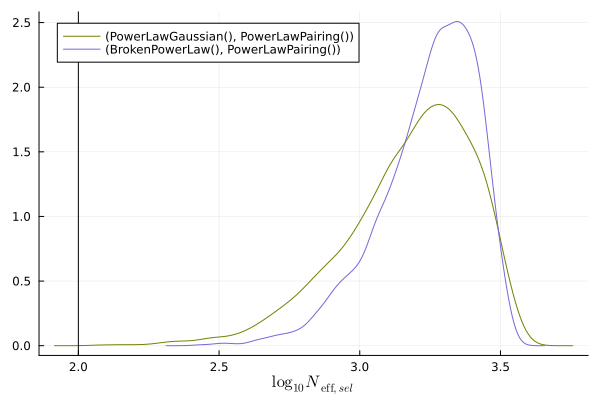

In [7]:
p = plot(xlabel=L"\log_{10} N_{\mathrm{eff}, sel}")
for (k, t) in pairs(traces)
    p = density!(log10.(vec(t.posterior.Neff_sel)), label=string(k))
end
p = vline!([log10(4 * size(traces[PowerLawGaussian(), PowerLawPairing()].posterior.m1s_popwt, 3))], color=:black, label=nothing)
p

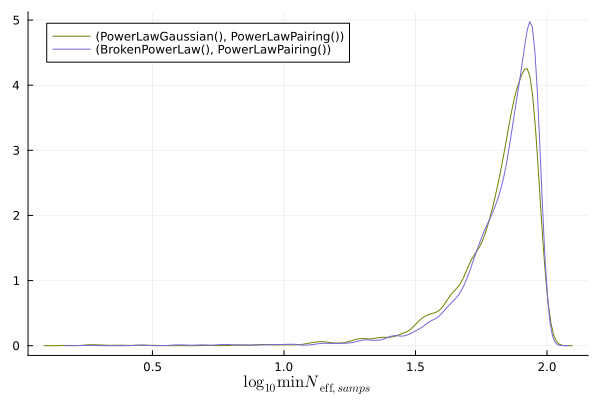

In [8]:
p = plot(xlabel=L"\log_{10} \min N_{\mathrm{eff}, samps}")
for (k, t) in pairs(traces)
    p = density!(log10.(vec(minimum(t.posterior.Neff_samps, dims=:gwnames))), label=string(k))
end
p

And we can take a quick look at the traceplots:

(PowerLawGaussian(), PowerLawPairing())
(BrokenPowerLaw(), PowerLawPairing())


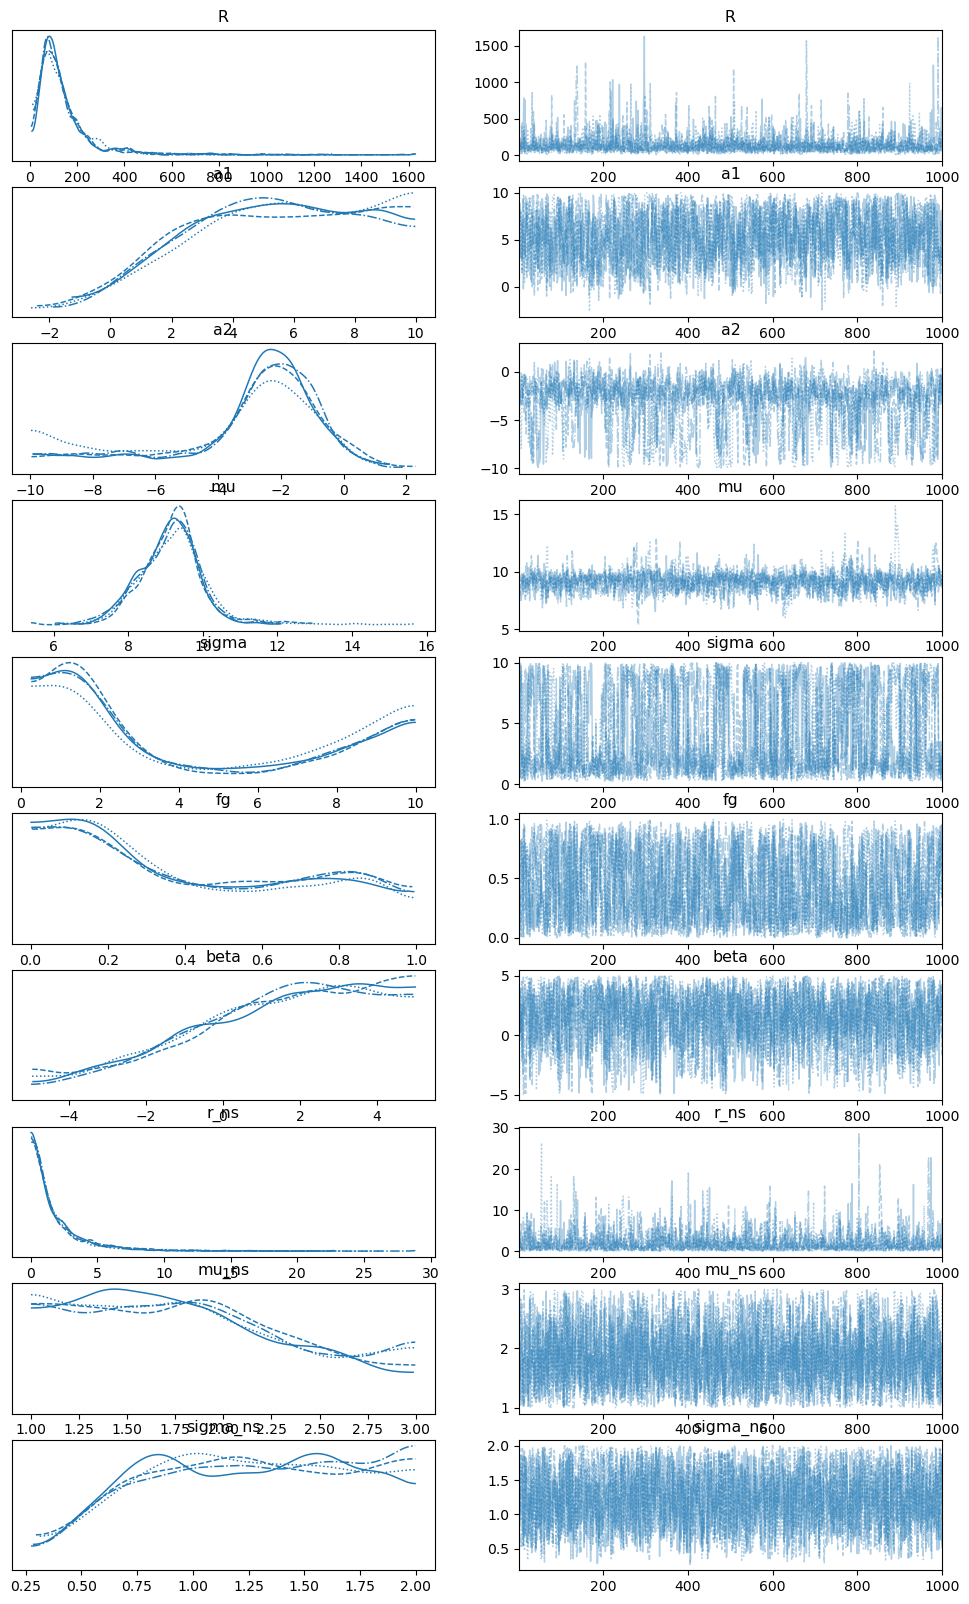

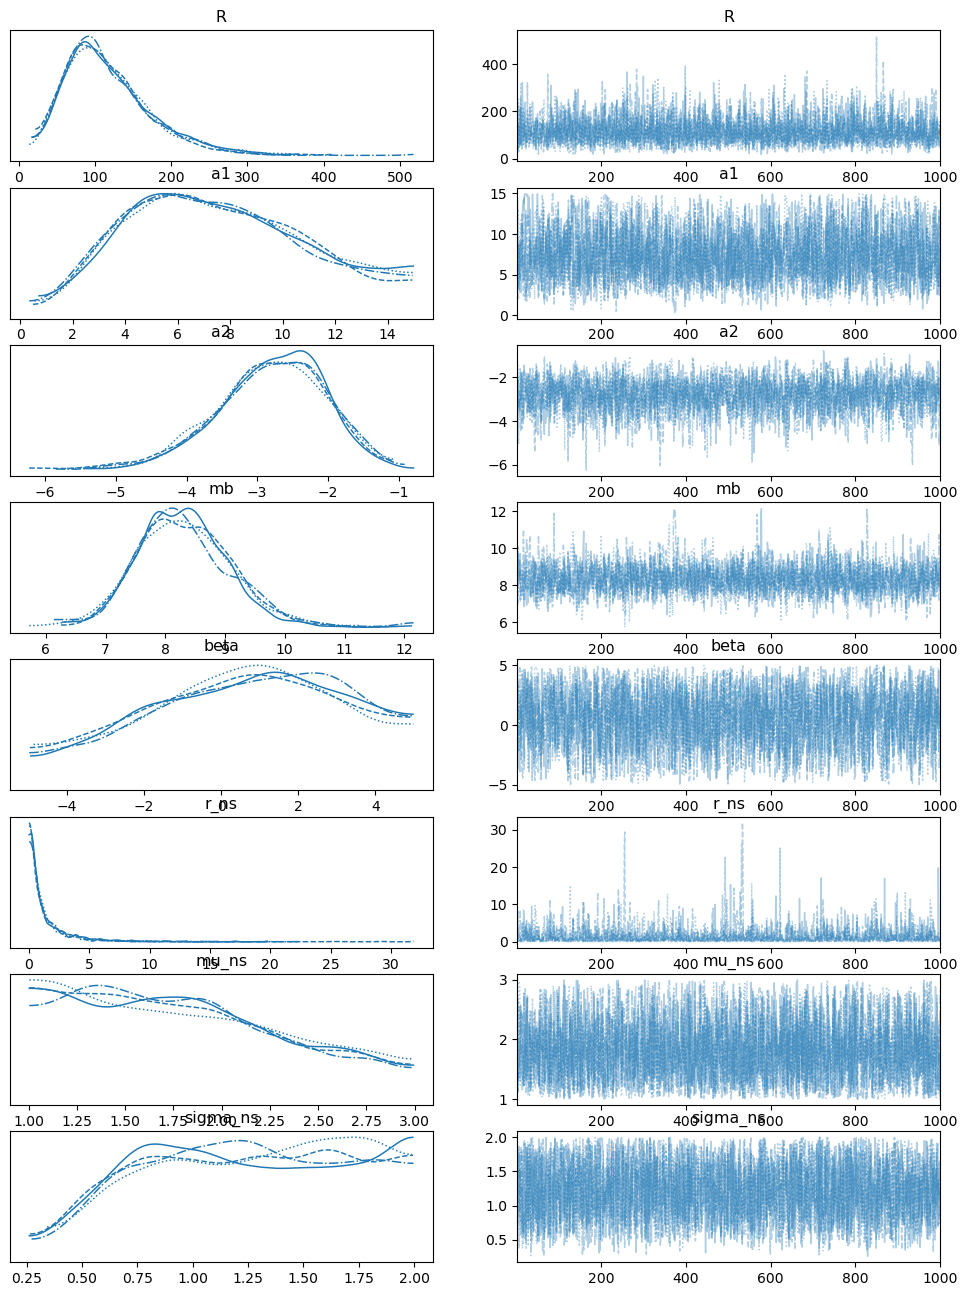

In [9]:
for (k, t) in pairs(traces)
    println(k)
    plot_trace(t, var_names=var_name_map[k[1:2]])
end

In [10]:
for (k, t) in pairs(traces)
    println(k)
    display(summarystats(t, var_names=var_name_map[k[1:2]]))
end

(PowerLawGaussian(), PowerLawPairing())


10×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         138.559  127.894    8.848  336.199      2.705    1.913    196 ⋯
   2 │ a1          5.371    2.759    0.966    9.991      0.076    0.056    120
   3 │ a2         -3.151    2.521   -9.316    0.133      0.113    0.08      54
   4 │ mu          9.137    0.856    7.449   10.547      0.024    0.018    140
   5 │ sigma       4.124    3.409    0.296    9.674      0.158    0.112     62 ⋯
   6 │ fg          0.418    0.296    0.003    0.903      0.01     0.007    110
   7 │ beta        1.383    2.397   -2.886    4.999      0.058    0.043    160
   8 │ r_ns        1.921    2.439    0.016    6.036      0.056    0.039    174
   9 │ mu_ns       1.85     0.538    1.0      2.796      0.01     0.007    289 ⋯
  10 │ sigma_ns    1.243    0.442    0.551    1.998      0.008    0.006    261
                                                               3 columns omitted

(BrokenPowerLaw(), PowerLawPairing())


8×10 DataFrame
 Row │ variable  mean     sd       hdi_3%   hdi_97%  mcse_mean  mcse_sd  ess_b ⋯
     │ String    Float64  Float64  Float64  Float64  Float64    Float64  Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ R         117.159   56.506   28.35   225.891      0.859    0.641    447 ⋯
   2 │ a1          7.567    3.298    2.272   14.069      0.068    0.051    229
   3 │ a2         -2.802    0.765   -4.207   -1.4        0.016    0.011    231
   4 │ mb          8.316    0.79     6.878    9.774      0.016    0.012    246
   5 │ beta        0.546    2.468   -3.682    4.985      0.054    0.038    203 ⋯
   6 │ r_ns        1.444    2.183    0.012    4.616      0.048    0.037    192
   7 │ mu_ns       1.815    0.531    1.001    2.745      0.009    0.007    337
   8 │ sigma_ns    1.239    0.446    0.545    1.995      0.008    0.006    310
                                                               3 columns omitted

## Mass Functions

In [11]:
dNdm1dm2_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    ldN = make_log_dN(k[1], k[2], args[2:end]...)
    (m1, m2) -> args[1]*exp(ldN(m1, m2))         
end for k in keys(traces))
dNdm1_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm1(k[1], k[2], args[2:end]...)
    m1 -> args[1]*dN(m1)
end for k in keys(traces))
dNdm2_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdm2(k[1], k[2], args[2:end]...)
    m2 -> args[1]*dN(m2)
end for k in keys(traces))
dNdq_map = Dict(k => map([traces[k].posterior[v] for v in var_name_map[k[1:2]]]...) do args...
    dN = make_dNdq(k[1], k[2], args[2:end]...)
    q -> args[1]*dN(q)
end for k in keys(traces))
pm_map = Dict(k => map([traces[k].posterior[v] for v in vcat(mf_var_name_map[k[1]], ns_var_names)]...) do args...
    make_dNdm(k[1], args[2:end]...)
end for k in keys(traces))

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{T, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, A, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata} where {T, A<:AbstractMatrix{T}}} with 2 entries:
  (PowerLawGaussian(), Pow… => var"#18#19"{PowerLawGaussian, NTuple{8, Float64}…
  (BrokenPowerLaw(), Power… => var"#18#19"{BrokenPowerLaw, NTuple{6, Float64}}[…

In [12]:
ms = exp.(log(m_lower_limit):0.01:log(m_upper_limit))
ms = ms[2:end-1]
qs = collect(range(m_lower_limit/m_upper_limit, 1, length=129))[2:end]

function make_mean_map(xs, dN_map)
    Dict(
        k => begin
            dN_mean = zeros(length(xs))
            for dN in v
                dN_mean .= dN_mean .+ dN.(xs)
            end
            dN_mean .= dN_mean ./ length(v)
            dN_mean
        end
        for (k,v) in pairs(dN_map)
    )
end

dN1_mean_map = make_mean_map(ms, dNdm1_map)
dN2_mean_map = make_mean_map(ms, dNdm2_map)
dNq_mean_map = make_mean_map(qs, dNdq_map)

Dict{Tuple{MassFunction, PowerLawPairing}, Vector{Float64}} with 2 entries:
  (PowerLawGaussian(), Pow… => [11.1176, 19.9004, 28.3636, 36.886, 45.4171, 53.…
  (BrokenPowerLaw(), Power… => [8.4123, 16.9365, 25.7309, 34.9664, 44.891, 55.3…

In [13]:
dN1_mean_map[BrokenPowerLaw(), PowerLawPairing()]

390-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.02252680201039951
 0.02177068944930288
 0.02091608044930083
 0.0200923992478496
 0.019298573004691934
 0.018654141703710842
 0.01791556191396766
 0.017203834507821068
 0.01651803372933459
 0.015857300110875498
 0.015331382271750748
 0.014716777628103786

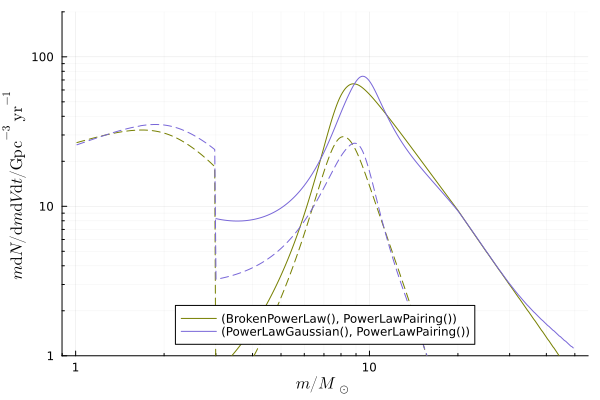

In [14]:
i = 1
p = plot(xlabel=L"m / M_\odot", ylabel=L"m \mathrm{d} N / \mathrm{d} m \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}", formatter=s->@sprintf("%.0f", s), minorgrid=true, yscale=:log10, ylims=(1, 200), xscale=:log10)
for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    pf = PowerLawPairing()
    k = (mf, pf)
    v = dN1_mean_map[k]
    p = plot!(ms, ms .* v, label=string(k), color=i)
    p = plot!(ms, ms .* dN2_mean_map[k], label=nothing, color=i, linestyle=:dash)
    i += 1
end
p = plot!(legend_position=:bottom)
p

How about the "common" part of the mass function?

In [15]:
pm_mean_map = Dict(
    k => begin
        pm = zeros(length(ms))
        for v in pm_map[k]
            p = v.(ms)
            p = p ./ trapz(ms, p)
            pm = pm .+ p
        end
        pm = pm / length(pm_map[k])
        pm
    end
    for k in keys(traces)
)

Dict{Tuple{MassFunction, PowerLawPairing}, Vector{Float64}} with 2 entries:
  (PowerLawGaussian(), Pow… => [0.472951, 0.470934, 0.468924, 0.466921, 0.46492…
  (BrokenPowerLaw(), Power… => [0.444331, 0.442341, 0.440355, 0.438372, 0.43639…

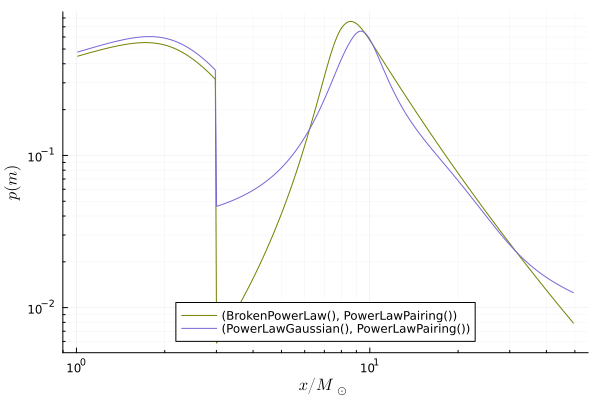

In [16]:
p = plot(xlabel=L"x/M_\odot", ylabel=L"p(m)", yscale=:log10, xscale=:log10, minorgrid=true, legend_position=:bottom)
for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    k = (mf, PowerLawPairing())
    v = pm_mean_map[k]
    p = plot!(ms, ms.*v, label=string(k))
end
p

What about $\mathrm{d} N / \mathrm{d} q \mathrm{d} V \mathrm{d} t$?

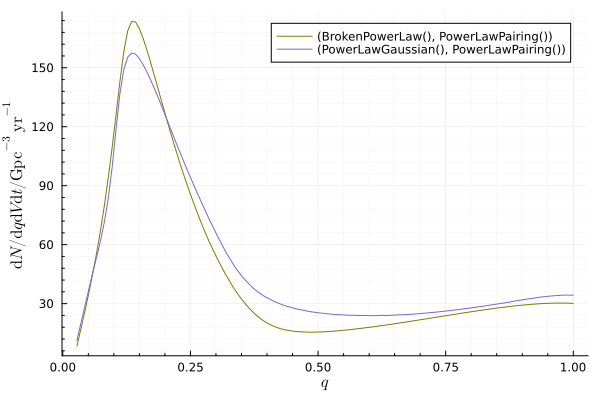

In [17]:
p = plot(xlabel=L"q", ylabel=L"\mathrm{d} N / \mathrm{d} q \mathrm{d} V \mathrm{d} t / \mathrm{Gpc}^{-3} \, \mathrm{yr}^{-1}", minorgrid=true)

for mf in [BrokenPowerLaw(), PowerLawGaussian()]
    pf = PowerLawPairing()
    k = (mf,pf)

    p = plot!(qs, dNq_mean_map[k], label=string(k))
end
p

## Peak Locations

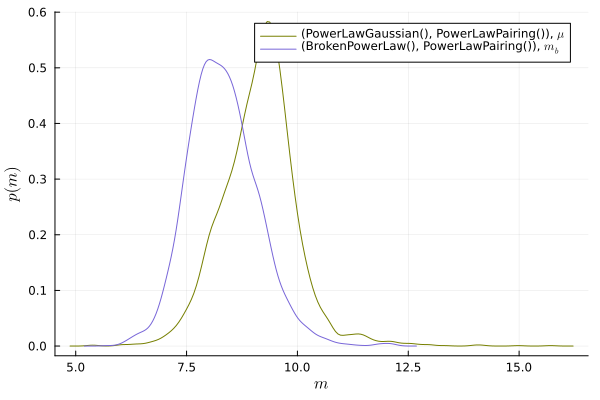

In [18]:
p = plot(xlabel=L"m", ylabel=L"p(m)")
for k in keys(traces)
    if k[1] === BrokenPowerLaw()
        p = density!(vec(traces[k].posterior.mb), label=string(k) * L", $m_b$")
    elseif k[1] === PowerLawGaussian()
        p = density!(vec(traces[k].posterior.mu), label=string(k) * L", $\mu$")
    end
end
p

The Gaussian + Power Law mass scale seems to be the best localized, so let's plot that alone:

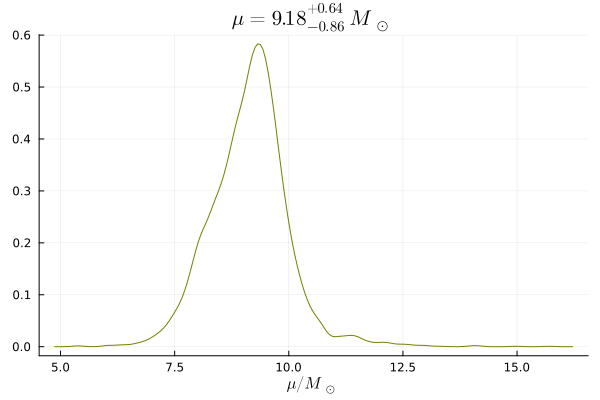

In [19]:
t = traces[(PowerLawGaussian(), PowerLawPairing())]
x = vec(t.posterior.mu)
m = median(x)
l = quantile(x, 0.16)
h = quantile(x, 0.84)

density(x, xlabel=L"\mu / M_\odot", title=@sprintf("\$\\mu = %.2f^{+%.2f}_{-%.2f} \\, M_\\odot\$", m, h-m, m-l), label=nothing)

## Model Selection

The plot below lets us read the Bayes factor in favor of the broken power law compared to the power law plus Gaussian model from the ratio of the posterior to the prior at $f_g = 0$; it is about 1.65 in favor of the broken power law model.

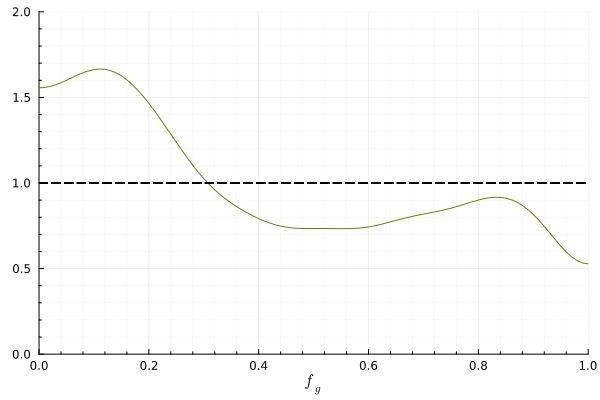

In [20]:
t = traces[PowerLawGaussian(), PowerLawPairing()]
k = BoundedKDE(vec(t.posterior.fg), lower=0, upper=1)

x = 0:0.01:1
p = plot(x, pdf.((k,), x), xlabel=L"f_g", label=nothing, minorgrid=true, xlims=(0,1), ylims=(0,2))
p = hline!(x, ones(length(x)), label=nothing, ls=:dash, color=:black)
p

## $m_{1\%}$

Here again we will look with the Gaussian + Power Law model:

In [21]:
function m1pct(f, mmin=3.0)
    ms = exp.(log(mmin):0.01:log(m_upper_limit))
    fm = f.(ms)
    cfm = cumtrapz(ms, fm)

    ms[argmin(abs.(cfm/cfm[end] .- 0.01))]
end

m1pct (generic function with 2 methods)

We begin with $m_{1\%}$ for the 50% selection:

In [22]:
m1pct_m1 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm1_map)
)
m1pct_m2 = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(dNdm2_map)
)
m1pct_m = Dict(
    k => map(v) do dN
        m1pct(dN)
    end
    for (k,v) in pairs(pm_map)
)

Dict{Tuple{MassFunction, PowerLawPairing}, DimArray{Float64, 2, Tuple{Dim{:draw, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}, Dim{:chain, DimensionalData.Dimensions.LookupArrays.NoLookup{Base.OneTo{Int64}}}}, Tuple{}, Matrix{Float64}, Symbol, DimensionalData.Dimensions.LookupArrays.NoMetadata}} with 2 entries:
  (PowerLawGaussian(), Pow… => [3.12243 6.10197 3.28252 3.15381; 5.86271 3.4164…
  (BrokenPowerLaw(), Power… => [5.52129 6.54442 6.41483 3.38249; 5.57678 3.5205…

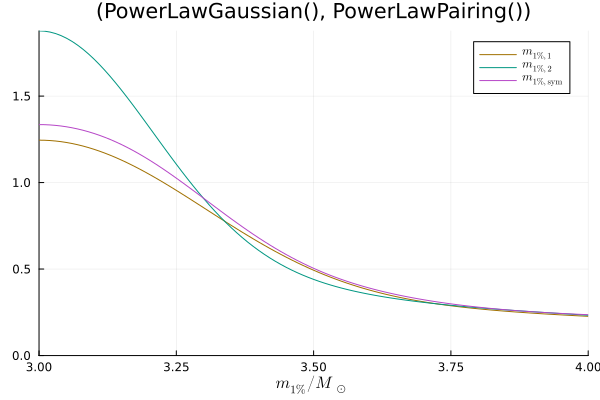

In [23]:
m1ps = 3:0.01:4
ymax = 1.6

k = (PowerLawGaussian(), PowerLawPairing())

p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 4), title=string(k), ylims=(0, Inf), palette=categorical_palette(3))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
end
p

And what about for the broken power law, where it looks more severe?

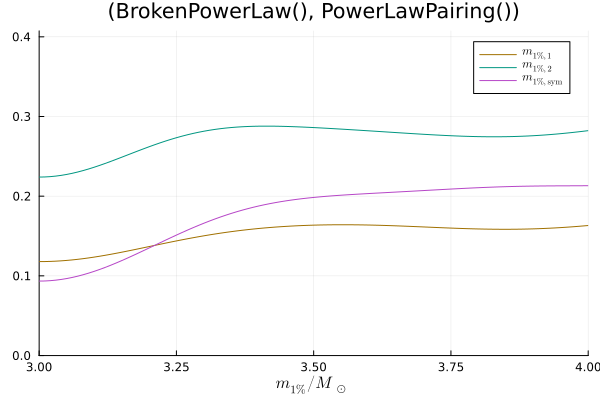

In [24]:
m1ps = 3:0.01:6
ymax = 1.6

k = (BrokenPowerLaw(), PowerLawPairing())

p = plot(xlabel=L"m_{1\%} / M_\odot", xlims=(3, 4), title=string(k), ylims=(0, Inf), palette=categorical_palette(3))
for (i, (ms, lab)) in enumerate(zip([m1pct_m1[k], m1pct_m2[k], m1pct_m[k]], [L"m_{1\%,1}", L"m_{1\%,2}", L"m_{1\%,\mathrm{sym}}"]))
    m = vec(ms)
    p = plot!(m1ps, pdf.((BoundedKDE(m, lower=3),), m1ps), label=lab, color=i)
end
p

In [25]:
for k in [(PowerLawGaussian(), PowerLawPairing()), (BrokenPowerLaw(), PowerLawPairing())]
    m1p = m1pct_m[k]
    m = median(vec(m1p))
    ll,l,h,hh = quantile.((vec(m1p),), [0.025, 0.16, 0.84, 0.975]) # hdi_interval(vec(m1p), 0.68)
    
    @printf("%s: m_1%% = %.3f + %.3f - %.3f (1-sigma) or [%.1f - %.1f] (2-sigma)\n", string(k), m, h-m, m-l, ll, hh)
end

(PowerLawGaussian(), PowerLawPairing()): m_1% = 3.486 + 1.561 - 0.363 (1-sigma) or [3.1 - 6.2] (2-sigma)
(BrokenPowerLaw(), PowerLawPairing()): m_1% = 5.148 + 0.893 - 1.218 (1-sigma) or [3.3 - 6.6] (2-sigma)


## Individual Masses

Let's do some model checking.  First, we plot the population-informed posteriors for $m_1$ and $m_2$:

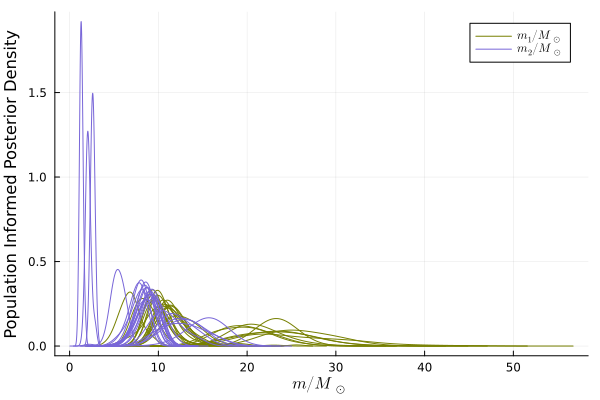

In [26]:
p = plot(xlabel=L"m / M_\odot", ylabel="Population Informed Posterior Density")
m1label = L"m_1 / M_\odot"
for n in DimensionalData.index(t.posterior, :gwnames)
    x = vec(t.posterior.m1s_popwt[gwnames=At(n)])
    p = density!(x, color=1, label=m1label, bandwidth=0.1*median(x))
    m1label = nothing
end
m2label = L"m_2 / M_\odot"
for n in DimensionalData.index(t.posterior, :gwnames)
    x = vec(t.posterior.m2s_popwt[gwnames=At(n)])
    p = density!(x, color=2, label=m2label, bandwidth=0.1*median(x))
    m2label = nothing
end
p

I bet our inference about the minimum BH mass is being driven by that one outlier.  Let's look:

In [27]:
nmin = ""
mmin = Inf
for n in DimensionalData.index(t.posterior, :gwnames)
    mm = minimum(t.posterior.m2s_popwt[gwnames=At(n)])

    if mm < mmin
        mmin = mm
        nmin = n
    end
    println("minimum(m2, $(n)): $(mm)")
end

println("Overall minimum is $(nmin)")

minimum(m2, GW151012_095443): 6.966572555984583
minimum(m2, GW151226_033853): 5.540994023973706
minimum(m2, GW170608_020116): 6.661855857734726
minimum(m2, GW190412_053044): 6.904592248960487
minimum(m2, GW190512_180714): 8.251459379356135
minimum(m2, GW190707_093326): 6.408719816639728
minimum(m2, GW190708_232457): 8.066296987388162
minimum(m2, GW190720_000836): 5.671880726879304
minimum(m2, GW190725_174728): 4.944291971771299
minimum(m2, GW190728_064510): 7.398041894713722
minimum(m2, GW190814_211039): 2.2981593915915126
minimum(m2, GW190828_065509): 7.769747162564778
minimum(m2, GW190917_114630): 1.4749791919628341
minimum(m2, GW190924_021846): 2.214139454364315
minimum(m2, GW190925_232845): 8.860738287580038
minimum(m2, GW190930_133541): 4.740994623743238
minimum(m2, GW191103_012549): 5.700227466947718
minimum(m2, GW191105_143521): 5.411760054459505
minimum(m2, GW191129_134029): 5.07879456323488
minimum(m2, GW191204_171526): 6.716157156189289
minimum(m2, GW191216_213338): 5.9493412

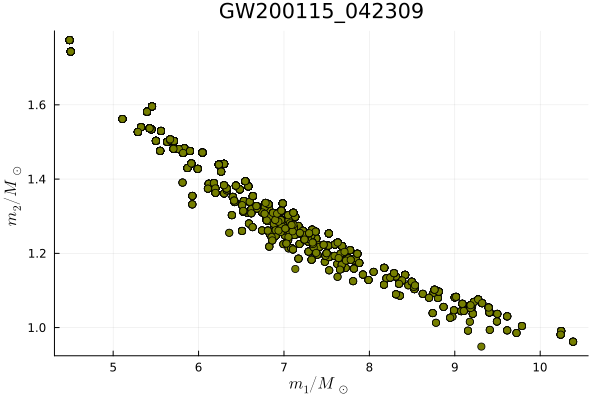

In [28]:
post = t.posterior
scatter(vec(post.m1s_popwt[gwnames=At(nmin)]), vec(post.m2s_popwt[gwnames=At(nmin)]), label=nothing, xlabel=L"m_1 / M_\odot", ylabel=L"m_2 / M_\odot", title=nmin)